# Example 7b: More advanced optimization

This example looks at optimizing a four-junction Ga$_{0.5}$In$_{0.5}$P/GaAs/SiGeSn/Ge cell, using a [*differential evolution* (DE) algorithm](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/).

First, using a purely optical TMM simulation to calculate the photogenerated current in each sub-cell, we get an estimate of the overall thickness of each material we will need to achieve current-matching. The thing to optimize is then the current of the current-limiting cell in the structure; in other words we want to *maximize* the lowest sub-cell current, to achieve current-matching with the highest possible current. Since the differential evolution algorithm as implemented does a minimization, we are actually minimizing the negative of this value.

Once we have good initial values for the total layer thicknesses, we use full electrical simulation to determine the n and p type layer thicknesses to calculate a maximum possible efficiency for the 4J device.

To use [yabox](https://github.com/pablormier/yabox) (used by Solcore's the optimization module for the DE) we need to define a class which sets up the problem and has an 'evaluate' function, which will actually calculate the value we are trying to minimize for a set of parameters.

*Note*: There is an issue in some versions of PyCharm with this example due to the parallel execution. To avoid this, make sure you "Run" the example as opposed to using "Run in Python Console".


In [1]:
import numpy as np

from solcore import material, si

import matplotlib.pyplot as plt

from solcore.optics.tmm import OptiStack
from solcore.optics.tmm import calculate_rat

from solcore.optimization import PDE, DE
from solcore.light_source import LightSource

from solcore.solar_cell import SolarCell
from solcore.structure import Junction, Layer
from solcore.solar_cell_solver import solar_cell_solver
from solcore.constants import q, kb
from solcore.absorption_calculator import search_db

First add SiGeSn optical constants to the database:

In [2]:
from solcore.material_system import create_new_material

create_new_material('SiGeSn', 'data/SiGeSn_n.txt', 'data/SiGeSn_k.txt', 'data/SiGeSn_params.txt')
# Note: comment out these lines after the material has been added to avoid being asked
# each time if you want to overwrite it.

In [3]:
n_iters_optics = 50
n_iters_device = 20

## Optical simulation

This example has a more complicated structure than the previous examples, and is based around the use of [Python `class`es](https://www.w3schools.com/python/python_classes.asp). For both steps of the optimization outlined above, we define a class which contains methods which generate all the information to run the simulations, and an `evaluate` method which actually returns the quantity to be optimized.

The methods defined in the `calc_min_Jsc` class below, which sets up the optical part of the optimization, are:

- `__init__`: This always has to be defined for a class, as it initializes a member of the class when we call the class as `calc_min_Jsc()`. In this case, it sets up variables we need in the simulation, such as the wavelength, light source, and optical constants of the materials.
- `calculate`: This actually runs the core of the calculation by calling `calculate_rat` from Solcore to run a TMM calculation; the argument of the function is a list of the layer thicknesses. It returns the absorption in each layer of the cell, the transmission, and reflection.
- `evaluate`: This function will be used to evaluate the figure of merit for the optimization. It calls `calculate` and then calculates the maximum possible current in each sub-cell using the photon flux. It then finds the limiting (minimum) $J_{sc}$ out of the four sub-cells, and returns the negative of this value. The way the DE algorithm is implemented means it will always try to minimize what the `evaluate` function returns, so although we want to *maximize* the limiting $J_{sc}$, we must implement this as *minimizing* its *negative*.
- `plot`: Takes the results from `calculate` and plots them to visualize our results.

In [4]:
class calc_min_Jsc():

    def __init__(self):
        # Initialize an instance of the class; set some information which will be used in each iteration of the calculation:
        # materials, wavelengths, the light source

        wl = np.linspace(300, 1900, 800)

        # Materials
        SiGeSn = material('SiGeSn')()

        GaAs = material('GaAs')()
        InGaP = material('GaInP')(In=0.5)
        Ge = material('Ge')()

        Ta2O5_index = search_db("Ta2O5/Rodriguez")[0][0]

        # We make these attributes of 'self' so they can be accessed by the class object
        # We are also creating lists of wavelengths and corresponding n and k data from
        # the Solcore materials - the reason for this is that there is currently an issue with using the Solcore
        # material class in parallel computations. Thus the information for the n and k data is saved here as a list
        # rather than a material object (see the documentation of OptiStack for the different acceptable formats
        # to pass optical constants for an OptiStack)

        self.wl = wl
        self.SiGeSn = [self.wl, SiGeSn.n(self.wl*1e-9), SiGeSn.k(self.wl*1e-9)]
        self.Ge = [self.wl, Ge.n(self.wl*1e-9), Ge.k(self.wl*1e-9)]

        self.InGaP = [self.wl, InGaP.n(self.wl*1e-9), InGaP.k(self.wl*1e-9)]
        self.GaAs = [self.wl, GaAs.n(self.wl*1e-9), GaAs.k(self.wl*1e-9)]
        self.MgF2 = [self.wl, material('MgF2')().n(self.wl*1e-9), material('MgF2')().k(self.wl*1e-9)]

        self.Ta2O5 = [self.wl, material(str(Ta2O5_index),
                                        nk_db=True)().n(self.wl*1e-9), material(str(Ta2O5_index),
                                                                                nk_db=True)().k(self.wl*1e-9)]

        # Assuming an AM1.5G spectrum
        self.spectr = LightSource(source_type='standard', version='AM1.5g', x=self.wl,
                           output_units='photon_flux_per_nm', concentration=1).spectrum(self.wl)[1]

    def calculate(self, x):
        # x[0] = MgF2 thickness (anti-reflection coating)
        # x[1] = Ta2O5 thickness (anti-reflection coating)
        # x[2] = InGaP (top junction) thickness
        # x[3] = GaAs (second junction) thickness
        # x[4] = SiGeSn (third junction) thickness

        # Keep the thickness of the bottom cell constant; from a purely optical point of view, this should be infinitely thick,
        # so there is no point in optimizing the thickness

        SC = [[x[0]] + self.MgF2, [x[1]] + self.Ta2O5, [x[2]] + self.InGaP, [x[3]] + self.GaAs, [x[4]] + self.SiGeSn,
              [300e3] + self.Ge]

        # create the OptiStack
        full_stack = OptiStack(SC, no_back_reflection=False)

        # calculate reflection, transmission, and absorption in each layer. We are specifying that the last layer,
        # a very thick Ge substrate, should be treated incoherently, otherwise we would see very narrow, unphysical oscillations
        # in the R/A/T spectra.

        c_list = ['c']*len(SC)
        c_list[-1] = "i"

        RAT = calculate_rat(full_stack, self.wl, no_back_reflection=False, coherent=False,
                            coherency_list=c_list)

        # extract absorption per layer
        A_InGaP = RAT['A_per_layer'][3]
        A_GaAs = RAT['A_per_layer'][4]
        A_SiGeSn = RAT['A_per_layer'][5]
        A_Ge = RAT['A_per_layer'][6]

        return A_InGaP, A_GaAs, A_SiGeSn, A_Ge, RAT['T'], RAT['R']

    def evaluate(self, x):

        A_InGaP, A_GaAs, A_SiGeSn, A_Ge, _, _ =  self.calculate(x)

        # Calculate photo-generated currents using the AM1.5 G spectrum for each layer -- this is the current with 100%
        # internal quantum efficiency (i.e. every absorbed photon generates an electron-hole pair which is collected).
        Jsc_InGaP = 0.1 * q * np.trapz(A_InGaP * self.spectr, self.wl)
        Jsc_GaAs = 0.1 * q * np.trapz(A_GaAs * self.spectr, self.wl)
        Jsc_SiGeSn = 0.1 * q * np.trapz(A_SiGeSn * self.spectr, self.wl)
        Jsc_Ge = 0.1 * q * np.trapz(A_Ge * self.spectr, self.wl)

        # Find the limiting current by checking which junction has the lowest current. Then take the negative since
        # we need to minimize (not maximize)
        limiting_Jsc = -min([Jsc_InGaP, Jsc_GaAs, Jsc_SiGeSn, Jsc_Ge])

        return limiting_Jsc

    def plot(self, x):

        A_InGaP, A_GaAs, A_SiGeSn, A_Ge, T, R = self.calculate(x)

        plt.figure()
        plt.plot(self.wl, A_InGaP, label='InGaP')
        plt.plot(self.wl, A_GaAs, label='A_GaAs')
        plt.plot(self.wl, A_SiGeSn, label='SiGeSn')
        plt.plot(self.wl, A_Ge, label = 'Ge')
        plt.plot(self.wl, T, label='T')
        plt.plot(self.wl, R, label='R')
        plt.legend()
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('R/A/T')
        plt.show()

Now that we have defined a class containing the relevant information and methods for the optimization process, we need to make an instance of that class for the DE algorithm to use.

In [5]:
#| output: false

DE_class = calc_min_Jsc()

Database file found at /Users/phoebe/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
475	main	Ta2O5	Rodriguez-de_Marcos	main/Ta2O5/Rodriguez-de Marcos.yml	1	1	0.0294938	1.51429	212
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ta2O5/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ta2O5/Rodriguez-de Marcos.yml loaded.


We also set the upper and lower bounds on thickness for each layer:

- MgF2 (ARC layer 1)
- Ta2O5 (ARC layer 2)
- GaInP (top junction)
- GaAs (2nd junction)
- SiGeSn (3rd junction)

We will not optimize the thickness of the bottom Ge cell at this stage; from a purely optical point of view, this should be infinitely thick to maximize absorption, which is of course not the case for a device. We will set the thickness of the Ge at 300 $\mu$m.

In [6]:
bounds_optics = [[10,150], [10,105], [200, 1000], [500, 10000], [500, 10000]]

Now, we pass the function which will be minimized to the DE (parallel differential evolution) solver. The bounds argument sets upper and lower bounds for each parameter. `PDE_obj` contains all the information to run the DE but does not actually start the calculation (like the `calc_min_Jsc` class defined above, `DE` is a *class* and not a *function*.

To actually run the DE, we use the .solve() method of the DE object class:

In [7]:
PDE_obj = DE(DE_class.evaluate, bounds=bounds_optics, maxiters=n_iters_optics)

res = PDE_obj.solve()

***Note***: *Due to issues with parallel computations depending on your operating system etc., we used the `DE` class here. There is also a parallelized version of this class, called `PDE`, which is already implemented above. If you are running this example on your own computer, you can run the example in parallel by simple changing `DE` to `PDE`.*

PDE_obj.solve() returns a list of five items:
- `res[0]` is a list of the parameters which gave the overall minimized value at the end of the process
- `res[1]` is that minimized value
- `res[2]` is the evolution of the best population (the best population from each iteration)
- `res[3]` is the evolution of the minimized value, i.e. the best fitness in iteration
- `res[4]` is the evolution of the mean fitness over the iterations

Let's plot the absorption in each layer using the optimized thicknesses:

parameters for best result: [ 119.25428258   83.4922207   550.47007392 2040.13817627 1420.56539299] 
 optimized Jsc value (mA/cm2): 14.031909365709433


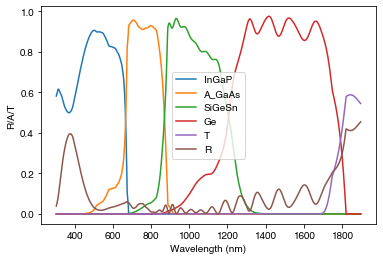

In [8]:
# best population:
best_pop = res[0]

print('parameters for best result:', best_pop, '\n', 'optimized Jsc value (mA/cm2):', -res[1])

# plot the result at these best parameters
DE_class.plot(best_pop)

And the evolution of the best and mean fitness with each iteration of the DE algorithm:

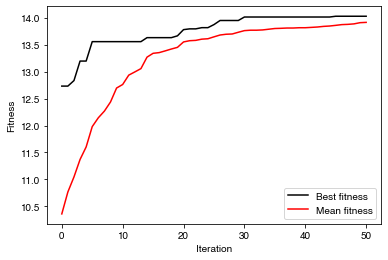

In [9]:
best_fitn_evo = res[3]
mean_fitn_evo = res[4]

# plot evolution of the fitness of the best population per iteration

plt.figure()
plt.plot(-best_fitn_evo, '-k', label='Best fitness')
plt.plot(-mean_fitn_evo, '-r', label='Mean fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.legend()
plt.show()

We see that the fitness of the best population 'jumps' every few iterations as a new best population is found, while the mean fitness increases slowly as the whole population gradually improves. Ideally, we would like to see the fitness converging, but it may be necessary to increase the number of iterations to achieve this.

## Device optimization

As discussed above, we approach this optimization in two phases: a faster optical simulation to get approximate total thicknesses for each junction, and then a device optimization. We take a very similar approach and define a class to contain the information and methods needed for the device optimization:

In [10]:
class optimize_device():

    def __init__(self, ARC_thickness):
        self.ARC = ARC_thickness
        self.position = [1e-10] * 10 + [5e-8] # 0.1 nm spacing in all layers except the Ge


    def make_cell(self, x):

        #x[0]: total InGaP thickness
        #x[1]: total InGaAs thickness
        #x[2]: total SiGeSn thickness
        #x[3]: total Ge thickness

        #x[4]: InGaP n thickness
        #x[5]: InGaAs n thickness
        #x[6]: SiGeSn n thickness
        #x[7]: Ge n thickness

        e_charge = si('1eV')

        # materials
        Ta2O5_index = search_db("Ta2O5/Rodriguez")[0][0]
        SiGeSn = material('SiGeSn')

        GaAs = material('GaAs')
        InGaP = material('GaInP')
        Ge = material('Ge')
        MgF2 = material('MgF2')()
        Ta2O5 = material(str(Ta2O5_index), nk_db=True)()
        AlInP = material("AlInP")

        window_material = AlInP(Al=0.52)

        GaInP_mobility_h = 0.03  #
        GaInP_lifetime_h = 1e-8
        GaInP_D_h = GaInP_mobility_h * kb * 300 / e_charge
        GaInP_L_h = np.sqrt(GaInP_D_h * GaInP_lifetime_h)
        GaInP_mobility_e = 0.015
        GaInP_lifetime_e = 1e-8
        GaInP_D_e = GaInP_mobility_e * kb * 300 / e_charge
        GaInP_L_e = np.sqrt(GaInP_D_e * GaInP_lifetime_e)

        top_cell_n_material = InGaP(In=0.5, Nd=si("2e18cm-3"), hole_diffusion_length=GaInP_L_h,
                                    hole_mobility=GaInP_mobility_h)
        top_cell_p_material = InGaP(In=0.5, Na=si("2e17cm-3"), electron_diffusion_length=GaInP_L_e,
                                    electron_mobility=GaInP_mobility_e)

        # MID CELL  - GaAs

        GaAs_mobility_h = 0.85  #
        GaAs_lifetime_h = 1e-8
        GaAs_D_h = GaAs_mobility_h * kb * 300 / e_charge
        GaAs_L_h = np.sqrt(GaAs_D_h * GaAs_lifetime_h)
        GaAs_mobility_e = 0.08
        GaAs_lifetime_e = 1e-8
        GaAs_D_e = GaAs_mobility_e * kb * 300 / e_charge
        GaAs_L_e = np.sqrt(GaAs_D_e * GaAs_lifetime_e)

        mid_cell_n_material = GaAs(Nd=si("1e18cm-3"), hole_diffusion_length=GaAs_L_h,
                                   hole_mobility=GaAs_mobility_h)
        mid_cell_p_material = GaAs(Na=si("1e17cm-3"), electron_diffusion_length=GaAs_L_e,
                                   electron_mobility=GaAs_mobility_e)


        SiGeSn.band_gap = si('0.77eV') # from PL measurement
        SiGeSn_L_h = si('0.35um')
        SiGeSn_L_e = si('5um')
        SiGeSn_lifetime_e = 1e-6
        SiGeSn_lifetime_h = 1e-6
        SiGeSn_mobility_h = SiGeSn_L_h ** 2 * e_charge / (SiGeSn_lifetime_h * kb * 300)
        SiGeSn_mobility_e = SiGeSn_L_e ** 2 * e_charge / (SiGeSn_lifetime_e * kb * 300)

        pen_cell_n_material = SiGeSn(Nd=si("1e18cm-3"), hole_diffusion_length=SiGeSn_L_h,
                                     relative_permittivity=16, hole_mobility=SiGeSn_mobility_h)
        pen_cell_p_material = SiGeSn(Na=si("1e17cm-3"), electron_diffusion_length=SiGeSn_L_e,
                                     relative_permittivity=16, electron_mobility=SiGeSn_mobility_e)

        Ge_lifetime_h = 1e-6
        Ge_L_h = si('500nm')
        Ge_mobility_h = Ge_L_h ** 2 * e_charge / (Ge_lifetime_h * kb * 300)
        Ge_mobility_e = 0.18
        Ge_lifetime_e = 1e-6
        Ge_D_e = Ge_mobility_e * kb * 300 / e_charge
        Ge_L_e = np.sqrt(Ge_D_e * Ge_lifetime_e)

        bot_cell_n_material = Ge(Nd=si("2e18cm-3"), hole_diffusion_length=Ge_L_h,
                                 hole_mobility=Ge_mobility_h)
        bot_cell_p_material = Ge(Na=si("1e17cm-3"), electron_diffusion_length=Ge_L_e,
                                 electron_mobility=Ge_mobility_e)



        solar_cell = SolarCell([
            Layer(si(self.ARC[0], 'nm'), material=MgF2), Layer(si(self.ARC[1], 'nm'), material=Ta2O5),
            Junction([Layer(si(25, 'nm'), material=window_material, role='window'),
                      Layer(si(x[4], 'nm'), material=top_cell_n_material, role='emitter'),
                      Layer(si(x[0]-x[4], 'nm'), material=top_cell_p_material, role='base'),
                      ], sn=1, sp=1, kind='DA'),
            Junction([Layer(si(x[5], 'nm'), material=mid_cell_n_material, role='emitter'),
                      Layer(si(x[1]-x[5], 'nm'), material=mid_cell_p_material, role='base'),
                      ], sn=1, sp=1, kind='DA'),
            Junction([Layer(si(x[6], 'nm'), material=pen_cell_n_material, role='emitter'),
                      Layer(si(x[2]-x[6], 'nm'), material=pen_cell_p_material, role='base'),
                      ], sn=1, sp=1, kind='DA'),
            Junction([Layer(si(x[7], 'nm'), material=bot_cell_n_material, role='emitter'),
                      Layer(si(x[3]-x[7], 'nm'), material=bot_cell_p_material, role='base'),
                      ], sn=1, sp=1, kind='DA'),
        ], shading=0.0, substrate=bot_cell_n_material)

        return solar_cell

    def calculate(self, x):

        light_source = LightSource(source_type='standard', version='AM1.5g')

        wl = np.linspace(300, 1850, 500) * 1e-9

        solar_cell = self.make_cell(x)

        V = np.linspace(0, 3.5, 300)
        solar_cell_solver(solar_cell, 'iv',
                          user_options={'voltages': V, 'light_iv': True, 'wavelength': wl, 'mpp': True,
                                        'light_source': light_source,
                                        'optics_method': 'TMM', 'BL_correction': True,
                                        'position': self.position})

        return wl, solar_cell

    def evaluate(self, x):

        _, solar_cell = self.calculate(x)
        efficiency = solar_cell.iv["Eta"]

        return -efficiency

    def plot(self, x):

        wl, solar_cell = self.calculate(x)

        V = solar_cell.iv['IV'][0]

        efficiency = solar_cell.iv["Eta"]
        pmax = solar_cell.iv["Pmpp"]
        ff = solar_cell.iv["FF"]
        voc = solar_cell.iv["Voc"]
        isc = solar_cell.iv["Isc"]

        plt.figure()

        plt.plot(V, solar_cell.iv['IV'][1] / 10, 'k', linewidth=3, label='Total')
        plt.plot(V, -solar_cell[2].iv(V) / 10, 'b', label='GaInP')
        plt.plot(V, -solar_cell[3].iv(V) / 10, 'g', label='GaAs')
        plt.plot(V, -solar_cell[4].iv(V) / 10, 'r', label='SiGeSn')
        plt.plot(V, -solar_cell[5].iv(V) / 10, 'y', label='Ge')
        plt.text(2, 10, '$\eta = $' + str(round(efficiency * 100, 1)) + '%')
        plt.text(2, 8,'Pmax='+str(round(pmax,1))+'W/m$^2$')
        plt.text(2, 9, 'FF = ' + str(round(ff * 100, 1)) + '%')
        plt.text(2,7,'Voc='+str(round(voc,1))+'V')
        plt.text(2,6, 'Jsc='+str(round(0.1*isc,1))+'mA/cm$^2$')

        plt.legend()
        plt.ylim(0, 18)
        plt.xlim(0, 3.5)
        plt.ylabel('Current (mA/cm$^2$)')
        plt.xlabel('Voltage (V)')

        plt.show()

        solar_cell_solver(solar_cell, 'qe',
                         user_options={'wavelength': wl, 'optics_method': 'TMM', 'BL_correction': True, 'position': self.position})

        plt.figure()
        plt.plot(wl * 1e9, solar_cell[2].eqe(wl) * 100, 'b', label='InGaP')
        plt.plot(wl * 1e9, solar_cell[3].eqe(wl) * 100, 'g', label='InGaAs')
        plt.plot(wl * 1e9, solar_cell[4].eqe(wl) * 100, 'r', label='SiGeSn')
        plt.plot(wl * 1e9, solar_cell[5].eqe(wl) * 100, 'y', label='Ge')
        plt.plot(wl * 1e9, solar_cell.absorbed * 100, 'k--', label='Absorption')
        # plt.plot(wl * 1e9, solar_cell[5].eqe(wl)*100, 'y', label='Ge')

        plt.legend(loc='upper right')
        plt.xlim(290, 1850)
        plt.ylim(0, 100)
        plt.ylabel('EQE (%)')
        plt.xlabel('Wavelength (nm)')
        plt.show()

Now that the layer thicknesses have been optimized from an optical point of view, we want to design the device (or
at least a simplified version, by calculating a more realistic EQE. Obviously additional parameters like the doping of the
layers could be varied too. The list of parameters `x` will be:

- x[0]: total InGaP thickness
- x[1]: total InGaAs thickness
- x[2]: total SiGeSn thickness
- x[3]: total Ge thickness

- x[4]: InGaP emitter thickness
- x[5]: InGaAs emitter thickness
- x[6]: SiGeSn emitter thickness
- x[7]: Ge emitter thickness

We will keep the ARC thicknesses fixed at the exact values obtained in the optical simulation. For the other layers, we generate upper and lower bounds: total layer thickness between 75% and 125% of values fitted in TMM calculation. For Ge, we set the starting value at 200 $\mu$m.

In [11]:
starting_params = np.append(best_pop[2:], [200000])

lower = 0.75*starting_params
upper = 1.25*starting_params

# upper and lower bounds for the n-type (highly doped) layers
lower_ntype = [20, 20, 20, 20]

upper_ntype = [200, 300, 300, 500]

all_lower = np.append(lower, lower_ntype)

all_upper = np.append(upper, upper_ntype)

# full list of bounds
all_bounds = np.stack((all_lower, all_upper)).T

Similar to the optical simulation above, we now create an object of this class (setting the ARC thickness when we create the class), then create an object of the `DE` class, and call the `.solve` method.

In [12]:
#| output: false

# DE calculation for the electrical simulation

DE_class_DA = optimize_device(best_pop[0:2])

# default population size = 5*number of params
PDE_obj_DA = DE(DE_class_DA.evaluate, bounds=all_bounds, maxiters=n_iters_device)

# solve, i.e. minimize the problem
res_DA = PDE_obj_DA.solve()

Database file found at /Users/phoebe/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
475	main	Ta2O5	Rodriguez-de_Marcos	main/Ta2O5/Rodriguez-de Marcos.yml	1	1	0.0294938	1.51429	212
Solving optics of the solar cell...
Treating layer(s) 10 incoherently
Calculating RAT...
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ta2O5/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ta2O5/Rodriguez-de Marcos.yml loaded.
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Database file found at /Users/phoebe/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
475	main	Ta2O5	Rodriguez-de_Marcos	main/Ta2O5/Rodriguez-de Marcos.yml	1	1	0.0294938	1.51429	212
Solving optics of the solar cell...
Treating layer

We plot the QE and IV for the best population:

parameters for best result: [5.64211912e+02 1.67613064e+03 1.08983977e+03 1.99726177e+05
 1.71208031e+02 1.18811297e+02 4.59410919e+01 1.07605130e+02] optimized efficiency (%) -35.688813260065366
Database file found at /Users/phoebe/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
475	main	Ta2O5	Rodriguez-de_Marcos	main/Ta2O5/Rodriguez-de Marcos.yml	1	1	0.0294938	1.51429	212
Solving optics of the solar cell...
Treating layer(s) 10 incoherently
Calculating RAT...
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ta2O5/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/phoebe/.solcore/nk/nk.db
Material main/Ta2O5/Rodriguez-de Marcos.yml loaded.
Calculating absorption profile...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


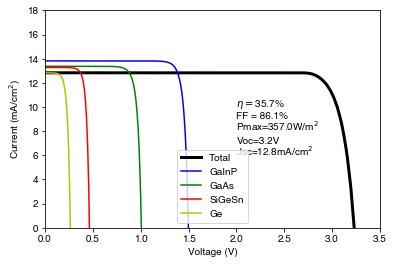

Solving optics of the solar cell...
Already calculated reflection, transmission and absorption profile - not recalculating. Set recalculate_absorption to True in the options if you want absorption to be calculated again.
Solving QE of the solar cell...


/Users/phoebe/Documents/develop/solcore5/solcore/analytic_solar_cells/depletion_approximation.py:617: RuntimeWarning: invalid value encountered in true_divide
  iqe =  j_sc / current_absorbed


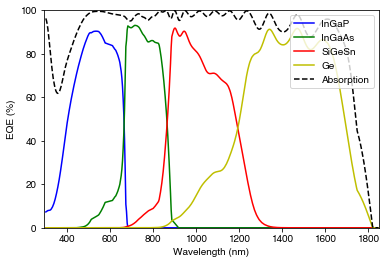

In [13]:
best_pop_DA = res_DA[0]

print('parameters for best result:', best_pop_DA, 'optimized efficiency (%)', res_DA[1]*100)

# plot the result at these best parameters
DE_class_DA.plot(best_pop_DA)

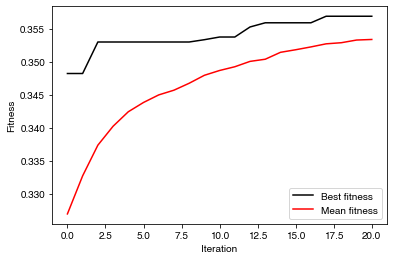

In [18]:
best_pop_evo = res_DA[2]
best_fitn_evo = res_DA[3]
mean_fitn_evo = res_DA[4]
final_fitness = res_DA[1]

# plot evolution of the fitness of the best population per iteration

plt.figure()
plt.plot(-best_fitn_evo, '-k', label='Best fitness')
plt.plot(-mean_fitn_evo, '-r', label='Mean fitness')
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.legend()
plt.show()

## Comparison

Compare the total layer thicknesses obtained from the optical and electrical simulations:

In [19]:
print("Comparison of thicknesses from optical/electrical optimization:")
print('GaInP total thickness: %.1f/%.1f nm' % (best_pop[2], best_pop_DA[0]))
print('GaAs total thickness: %.1f/%.1f nm' % (best_pop[3], best_pop_DA[1]))
print('SiGeSn total thickness: %.1f/%.1f nm' % (best_pop[4], best_pop_DA[2]))

Comparison of thicknesses from optical/electrical optimization:
GaInP total thickness: 550.5/564.2 nm
GaAs total thickness: 2040.1/1676.1 nm
SiGeSn total thickness: 1420.6/1089.8 nm


**NOTE**: You may have an issue running the parallel version of this example (change `DE` to `PDE`) if you are using Windows. To get around this, you need to use the [`if __name__ == "__main__"`](https://stackoverflow.com/questions/419163/what-does-if-name-main-do) construction. The issue arises because the multiprocessing module uses a different process on Windows than on UNIX systems which will throw errors if this construction is not used. You need to put everything apart from the module imports at the top of the script and the class definitions inside a function called `main`, and execute this with:

In [20]:
# if __name__ == '__main__':
#     main()